# Fuzzy Match of Firm Names

In [2]:
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/maxfacts/anaconda/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
#Load CFPB and OAG data
silvercase = pd.read_csv("OAG Complaints-Online_Final.csv")
cfpb = pd.read_csv('Consumer_Complaints.csv')

In [ ]:
#Only examine unique firm names
CFPBlist = list(cfpb.Company.unique().astype('str'))

In [ ]:
#Combine CFPB and OAG and create dummy column 'cusp_firm_name'
OAGlist = list(silvercase.ENTITY_ORG_NAME.astype('str')) + CFPBlist
OAGlist = [str(i) for i in OAGlist]
OAGlist = pd.DataFrame(OAGlist, columns= ['firm'])
OAGlist['cusp_firm_name'] = OAGlist.firm

In [ ]:
#create a dataftame that counts the occurance of each firm name in the
#combinded databases and select those that occur more than 5 times
counts = OAGlist.cusp_firm_name.value_counts()
high_counts = pd.DataFrame(counts[counts > 5])
high_counts.reset_index(inplace = True)
high_counts.columns = ['high_count_firms', 'counts']
high_counts.head()

In [ ]:
counts = pd.DataFrame(counts)
counts.reset_index(inplace = True)

In [ ]:
#fuzzymatch each 'high_count_firm' with every other firm name in the database
#if the fuzzymatch score gets sufficently high (here 90) then replace the
#high_count_firm name in the place of the other matched firm names

counter = 0
firms_dropped = []
start_firms = len(OAGlist.cusp_firm_name.unique())
start = time.time()
for OAGlist_firm_name in high_counts.high_count_firms:
    counter += 1
    #begin = len(OAGlist.firm.unique())
    #print 'step %s started with %s firms' % (counter, begin)
    tempfuzz = pd.DataFrame(process.extract(OAGlist_firm_name, OAGlist.cusp_firm_name.unique(), limit = 30), columns= ['FirmName', 'FuzzScore'])
    tempfuzz = tempfuzz[tempfuzz.FuzzScore >= 90]
    for temp_firm_name in tempfuzz.FirmName:
        OAGlist.cusp_firm_name = OAGlist.cusp_firm_name.replace(temp_firm_name, OAGlist_firm_name)
        firms_dropped.append((temp_firm_name, OAGlist_firm_name))
    end_firms = len(OAGlist.cusp_firm_name.unique()) 
    #print 'step %s ended with %s firms dropped' % (counter, (begin-end_firms))
    #print 'step took %s minutes' % (float(end-start)/60)
end = time.time()
end_firms = len(OAGlist.cusp_firm_name.unique())
print 'oy this took %s minutes' % (float(end-start)/60)
print 'While doing it dropped %s firms or %s percent' % (start_firms-end_firms, (float(start_firms-end_firms)/start_firms*100))

In [ ]:
#If we want to see dropped firm names here they are!
firms_dropped

In [3]:
#save to pickle and csv
OAGlist.to_pickle('OAGlist.pkl')
import csv
res = OAGlist.firm.unique()
csvfile = "final_firm_list_w_fuzzy.csv"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in res:
        writer.writerow([val])    


NameError: name 'OAGlist' is not defined

In [4]:
oag = pd.read_pickle('OAGlist.pkl')

In [5]:
old_counts = oag.firm.value_counts()
new_counts = oag.cusp_firm_name.value_counts()

In [ ]:
old_counts[old_counts > 2].hist()

In [ ]:
numpy.linspace(0, 10, 100)

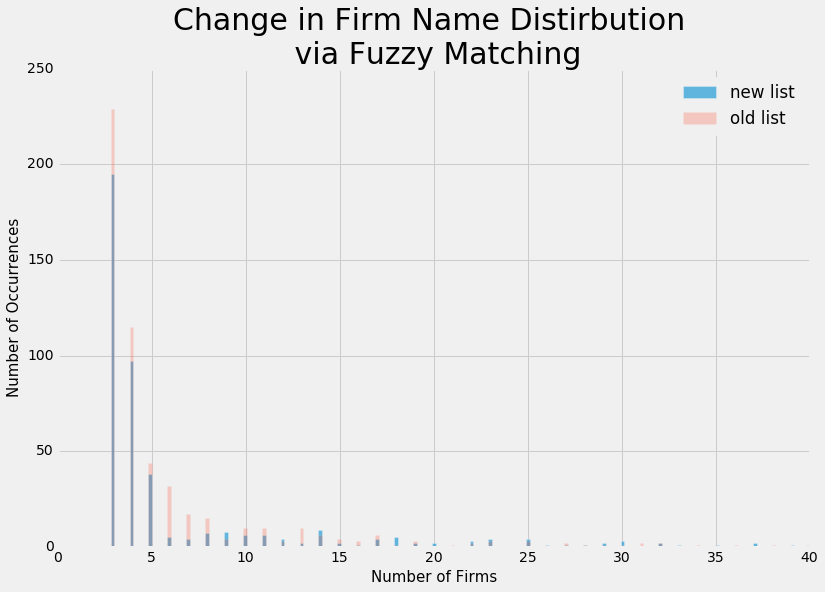

In [10]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize = (12, 8))
bins = numpy.linspace(0, 40, 200)
plt.hist(new_counts[new_counts > 2], bins, alpha=0.75, label='new list')#, color = 'b')
plt.hist(old_counts[old_counts > 2], bins, alpha=0.25, label='old list')#, color = 'r')
plt.legend(loc='upper right')

plt.title('Change in Firm Name Distirbution \n via Fuzzy Matching', size = 30)
plt.ylabel('Number of Occurrences', size = 15)
plt.xlabel('Number of Firms', size = 15)